# Thermal food processing surrogate
Part B: Varying number of training trajectories.

In [ ]:
import sys; sys.path.append('../../..')   # Allow relative imports from the parent folder

import numpy as np

from matplotlib import pyplot as plt 

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
from jaxtyping import Array

import optax

import equinox as eqx

from dynax import training
from dynax import evaluation
from dynax.function_models import LyapunovNN, OnsagerNetPotential, FICNN, \
                                  ConstantSkewSymmetricMatrix, \
                                  ConstantMatrix, ConstantSPDMatrix, \
                                  MLP
from dynax.integration_models import ODESolver
from dynax.derivative_models import BaseModel, ISPHS
from dynax.losses import mse
from dynax.sphnn_tools import is_zero_gas_guarantee_valid
from dynax.data_handling import Normalizer, NormalizationWrapper

from pathlib import Path
import json

from functools import partial
from collections import defaultdict

from util import colors
from util.model_meta import model_names, model_style

ACTIVATIONS = dict(
    softplus = jax.nn.softplus,
    tanh = jax.nn.tanh,
    relu = jax.nn.relu,
)

INITIALIZERS = dict(
    he_uniform = jax.nn.initializers.he_uniform(),
    glorot_uniform = jax.nn.initializers.glorot_uniform(),
    zeros = jax.nn.initializers.zeros,
)

### Matplotlib Settings 
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors.set_custom_cycle()

PLOT_DPI = 200

## Model and training definitions

In [9]:
def define_sPHNN_model(model_hyperparams: dict,
                       num_aug: int,
                       *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'], # Hardcoded old version: jnn.initializers.glorot_uniform(),
                  b_initializer=model_hyperparams['bias_initialization'],   # Hardcoded old version: jnn.initializers.normal(),
                  key=h_key)
    H = LyapunovNN(ficnn, minimum=jnp.zeros(state_size))
    sphnn_ = ISPHS(H, J, R, g)
    sphnn_ode = ODESolver(sphnn_, augmentation=num_aug, augmentation_learnable=False)

    return sphnn_ode

def define_sPHNN_LM_model(model_hyperparams: dict,
                          num_aug: int,
                          *, key):
    j_key, r_key, g_key, h_key, minimum_key = jr.split(key, 5)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix(
        (state_size, input_size), initialize=jnn.initializers.zeros, key=g_key
    )

    ficnn = FICNN(
        state_size,
        "scalar",
        width=model_hyperparams["ficnn_width"],
        depth=model_hyperparams["ficnn_depth"],
        activation=jnn.softplus,
        w_initializer=model_hyperparams["weight_initialization"],
        b_initializer=model_hyperparams["bias_initialization"],
        key=h_key,
    )
    _H = LyapunovNN(ficnn)
    initial_minimum = jax.nn.initializers.normal(
        model_hyperparams["minimum_initializer_std"]
    )(minimum_key, _H.minimum.shape)
    H = eqx.tree_at(lambda x: x.minimum, _H, initial_minimum)
    assert H.minimum_learnable, "Minimum is not learnable for sPHNN_LM"
    sphnn_ = ISPHS(H, J, R, g)
    sphnn_ode = ODESolver(sphnn_, augmentation=num_aug, augmentation_learnable=False)

    return sphnn_ode

def define_PHNN_model(model_hyperparams: dict,
                      num_aug: int,
                      *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = MLP(in_size=state_size, out_size='scalar', 
            width_size=model_hyperparams['mlp_width'],
            depth=model_hyperparams['mlp_depth'],
            weight_initializer=model_hyperparams['weight_initialization'],
            bias_initializer=model_hyperparams['bias_initialization'],  
            activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
            key=h_key)
    phnn_ = ISPHS(H, J, R, g)
    phnn_ode_ = ODESolver(phnn_, augmentation=num_aug, augmentation_learnable=True) # 1 Parameters

    return phnn_ode_

def define_NODE_model(model_hyperparams: dict,
                      num_aug: int,
                      *, key):
    
    state_size, input_size = 2 + num_aug, 1

    mlp = MLP(state_size+input_size, state_size, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'], # Old hardcoded version: jnn.tanh,
              key=key)
    div_model = BaseModel(mlp, state_size, input_size)
    node = ODESolver(div_model, augmentation=num_aug, augmentation_learnable=True,
                     max_steps=8192,    # Hopefully all nodes can be integrated by increasing the max steps.
                     )

    return node

def define_cPHNN_model(model_hyperparams: dict,
                       num_aug: int,
                       *, key):

    j_key, r_key, g_key, h_key= jr.split(key, 4)

    state_size, input_size = 2 + num_aug, 1

    J = ConstantSkewSymmetricMatrix(state_size, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = OnsagerNetPotential(
        state_size, 
        width_size=model_hyperparams['mlp_width'],
        depth=model_hyperparams['mlp_depth'],
        activation=model_hyperparams['activation'],
        weight_initializer=model_hyperparams['weight_initialization'],
        bias_initializer=model_hyperparams['bias_initialization'],  
        beta=model_hyperparams['beta'], 
        beta_learnable=model_hyperparams['beta_learnable'], 
        key=h_key
    )

    cphnn_ = ISPHS(H, J, R, g)
    cphnn_ode_ = ODESolver(cphnn_, augmentation=num_aug, augmentation_learnable=True)

    return cphnn_ode_

def get_rmse(model, ts, ys, us):
    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
    return jnp.sqrt(jnp.mean(jnp.square(ys_pred - ys)))

def train_template(model, 
                   training_data: tuple, validation_data: tuple|None,
                   training_hyperparams: dict,
                   weights_dir:Path, overwrite=False,
                   loss_fn = mse,
                   *, key):

    try:
        model = training.load_weights(weights_dir/Path('weights.eqx'), model)
        history = training.load_history(weights_dir/Path('history.npz'))

    except FileNotFoundError:
        model, history = training.fit_trajectory(
            model, *training_data,
            validation_data = validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['batch_size'],
            steps           = training_hyperparams['steps'],
            optimizer       = optax.adam(training_hyperparams['learning_rate']),
            log_loss_every  = 100,
            callback        = training.save_every(5000, weights_dir/'checkpoint'),
            key             = key
            )
        
        training.save_weights(weights_dir/Path('weights'), model, overwrite)
        training.save_history(weights_dir/Path('history'), history, overwrite)

    return model, history

def evaluation_template(model, 
                        metrics_dir: Path,
                        **datasets: tuple):
    
    # Load RMSE data if available, otherwise compute it
    try:
        error_measures = np.load(metrics_dir/Path('error_measures.npz'))
        error_measures = dict(error_measures)
    except FileNotFoundError:
        print('Couldnt find error measures')
        error_measures = dict()

    # Check if the saved metrics contain all requested metrics
    save_necessary = False
    for key, data in datasets.items():
        metric = key+'_rmse'
        if metric not in error_measures:
            error_measures[metric] = get_rmse(model, *data)
            save_necessary = True

    if save_necessary:
        np.savez(metrics_dir/Path('error_measures.npz'), **error_measures)

    return error_measures


def get_prediction_statistics(ts: Array, ys: Array, us: Array, results:dict, error_metric=evaluation.rmse, exclude_model_types=[]):

    # Add batch dimension if only a single trajectory is passed
    ys = evaluation.make_batched(ys)
    us = evaluation.make_batched(us)

    true_data = dict(
        ts = ts, ys = ys, us = us
    )
    prediction_data = {}
    for model_type, model_results in results.items():
        if model_type in exclude_model_types:
            continue
        
        prediction_data[model_type] = {}
        for aug_dim, aug_results in model_results.items():
            ys_preds = []
            errors = []
            for n, instance_result in enumerate(aug_results):
                model = instance_result['wrapped_model']
                try:
                    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
                    ys_preds.append(ys_pred)
                    errors.append(error_metric(ys_pred, ys))
                except Exception as e:
                    print(f'{model_type}, instance {n} faild to integrate. {e}')
                
            ys_preds = np.stack(ys_preds, axis=0)
            errors = np.stack(errors, axis=0)
            print(f'# of valid {model_type} predictions: {ys_preds.shape[0]}')
            prediction_data[model_type][aug_dim] = dict(
                ys      = evaluation.get_statistics(ys_preds),
                errors  = evaluation.get_statistics(errors),
            )
    return prediction_data, true_data

def get_hyperparams(file: Path, default_hyperparamse: dict):
    file = Path(file)
    try:
        with open(file, 'r') as f:
            hyperparams = json.load(f)
        return hyperparams

    except FileNotFoundError:
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, 'w') as f:
            json.dump(default_hyperparamse, f, indent=4)
        return default_hyperparamse

## Load the data

In [10]:
train_ids = [745, 795]
test_ids  = [313, 320, 344, 378, 383, 407, 412, 415, 461, 462, 466, 467, 474, 508, 528] # Test group AP15

data = np.load('../../data/thermal_food_processing_surrogate/data.npz')
ts_train, ys_train, us_train = data['ts_train'], data['ys_train'], data['us_train']
ts_vali,  ys_vali,  us_vali  = data['ts_vali'],  data['ys_vali'],  data['us_vali'] 

#### Normalize data

In [11]:
ts_shift = 0.
ts_scale = jnp.std(ts_train - ts_shift)
t_normalizer = Normalizer(ts_shift, ts_scale)

ys_shift = 279.15
ys_scale = jnp.std(ys_train - ys_shift)
y_normalizer = Normalizer(ys_shift, ys_scale)

us_shift = 279.15
us_scale = jnp.std(us_train - us_shift)
u_normalizer = Normalizer(us_shift, us_scale)

# Compute the normalized data
def get_normalized(ts, ys, us):
    ts_norm  = t_normalizer.normalize(ts)
    ys_norm  = y_normalizer.normalize(ys)
    us_norm  = u_normalizer.normalize(us)
    return ts_norm, ys_norm, us_norm

ts_train_norm, ys_train_norm, us_train_norm = get_normalized(ts_train, ys_train, us_train)
ts_vali_norm, ys_vali_norm, us_vali_norm  = get_normalized(ts_vali,  ys_vali,  us_vali )
vali_data_norm = ((ts_vali_norm, ys_vali_norm[:,0], us_vali_norm), ys_vali_norm)
test_data  = (ts_vali,  ys_vali,  us_vali )

# Function to wrap trained models
def attach_normalizer(model: eqx.Module):
    return NormalizationWrapper(model, t_normalizer, y_normalizer, u_normalizer)

## Set Hyperparameters
The following sets the hyperparameters for the experiment and/or the directory to save/load the trained models to.

In [12]:

# Directory of the files for saving or loading
save_dir = Path(R'results/run_B0')

default_hyperparams = {
    'meta': dict(
        description = 'I am testing now training for a little longer and using bigger nets. Also I added cPHNNs.',
        num_instances = 5,
        augmentations = [3],
        nums_train_trajectories = [1,2,3,4,5,10,25,50],
    ),
    'sPHNN': dict(
        ficnn_width             = 32,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'PHNN': dict(
        mlp_width               = 32,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'NODE': dict(
        mlp_width               = 32,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'cPHNN': dict(
        mlp_width               = 32,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus',
        beta                    = 0.1,
        beta_learnable          = False,
    ),
    'training': dict(
        batch_size      = 32,
        steps           = 50_000,
        learning_rate   = 2e-4,
    ),
}

# Load hyperparameters / Save hyperparameters if new experiment
hyperparams = get_hyperparams(save_dir/'hyperparameters.json', default_hyperparams)

# Substitute the activations and intialization schemes
for model in hyperparams.values():
    if 'activation' in model.keys():
        model['activation'] = ACTIVATIONS[model['activation']]
    if 'weight_initialization' in model.keys():
        model['weight_initialization'] = INITIALIZERS[model['weight_initialization']]
    if 'bias_initialization' in model.keys():
        model['bias_initialization'] = INITIALIZERS[model['bias_initialization']]

## Train (or load) models

In [14]:
model_definitions = {
    'sPHNN':    partial(define_sPHNN_model, 
                        model_hyperparams      = hyperparams['sPHNN']),
    'sPHNN-LM': partial(define_sPHNN_LM_model, 
                        model_hyperparams      = hyperparams['sPHNN-LM']),
    'cPHNN':    partial(define_cPHNN_model, 
                        model_hyperparams      = hyperparams['cPHNN']),
    'PHNN':     partial(define_PHNN_model,
                        model_hyperparams      = hyperparams['PHNN']),
    'NODE':     partial(define_NODE_model,
                        model_hyperparams      = hyperparams['NODE']),
}



# Load/Train the models
num_instances = hyperparams['meta']['num_instances']
results = {}
for model_name, definition in model_definitions.items():

    dat_results = {}
    for num_train_trajectories in hyperparams['meta']['nums_train_trajectories']:

        # Complete training definition by choosing the training data
        train_data_norm = (ts_train_norm, ys_train_norm[:num_train_trajectories], us_train_norm[:num_train_trajectories])
        train_data = (ts_train, ys_train[:num_train_trajectories], us_train[:num_train_trajectories])

        train_model = partial(train_template,
                            training_data = train_data_norm,
                            validation_data = vali_data_norm,
                            training_hyperparams = hyperparams['training'],
                            loss_fn = mse)

        evaluate_model = partial(evaluation_template,
                                 train = train_data,
                                 test = test_data)

        aug_results = {}
        for num_aug in hyperparams['meta']['augmentations']:

            print(f'{model_name:<8}, num_dat: {num_train_trajectories:>2}, num_aug: {num_aug:>1}')

            def train_instance(instance_id: int):
                key = jr.key(instance_id)
                model_key, loader_key = jr.split(key, 2)

                # Define the model
                _model = definition(num_aug=num_aug, key=model_key)

                # Train or load the model
                if model_name == "sPHNN-LM":
                    weights_dir=save_dir/model_name/f'augment_{num_aug}'/f'dat_{num_train_trajectories}'/"noise_0.0"/f'instance_{instance_id}'
                else:
                    weights_dir=save_dir/model_name/f'dat_{num_train_trajectories}'/f'augment_{num_aug}'/f'instance_{instance_id}'
                _model, history = train_model(_model,
                                            weights_dir=weights_dir,
                                            key=loader_key)
                model = training.resolve_constraints(_model)

                # Wrap the model
                wrapped_model = attach_normalizer(model)

                # Evaluate the model
                error_measures = evaluate_model(wrapped_model, 
                                                metrics_dir=weights_dir)

                instance_result = dict(
                    model = model,
                    wrapped_model = wrapped_model,
                    history = history,
                ) | error_measures

                return instance_result
            
            # Threading is for some reason slower than running sequentially
            # with Pool(5) as p:
            #     aug_results[num_aug] = p.map(train_instance, range(num_instances))

            # For debugging run sequentially
            aug_results[num_aug] = []
            for i in range(num_instances):
                print(Rf'{model_name:<8}, num_dat: {num_train_trajectories:>2}, num_aug: {num_aug:>1}, Instance: {i}/{num_instances-1}')
                aug_results[num_aug].append(train_instance(i))

        dat_results[num_train_trajectories] = aug_results

    results[model_name] = dat_results

sPHNN   , num_dat:  1, num_aug: 3
sPHNN   , num_dat:  1, num_aug: 3, Instance: 0/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 1/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 2/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 3/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 4/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 5/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 6/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 7/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 8/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 9/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 10/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 11/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 12/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 13/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 14/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 15/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 16/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 17/19
sPHNN   , num_dat:  1, num_aug: 3, Instance: 18/19
sPHNN  

#### Check if all sPHNNs are 0-GAS (Globally asymptotically stable)

In [16]:
for model_name in ['sPHNN', 'sPHNN-LM']:
    all_passed = True
    for num_dat, dat_results in results[model_name].items():
        for num_aug, aug_results in dat_results.items():
            for n, instance_result in enumerate(aug_results):
                isphs = instance_result['model'].derivative_model
                if not is_zero_gas_guarantee_valid(isphs, 1e-6):
                    all_passed = False
                    print(f'{model_name}, augment {num_aug}, instance {n} might not be 0-GAS.')
    if all_passed:
        print(f'All {model_name} instances are 0-GAS')

All sPHNN instances are 0-GAS
All sPHNN-LM instances are 0-GAS


## Evaluation
#### Test RMSE per data amount

[]

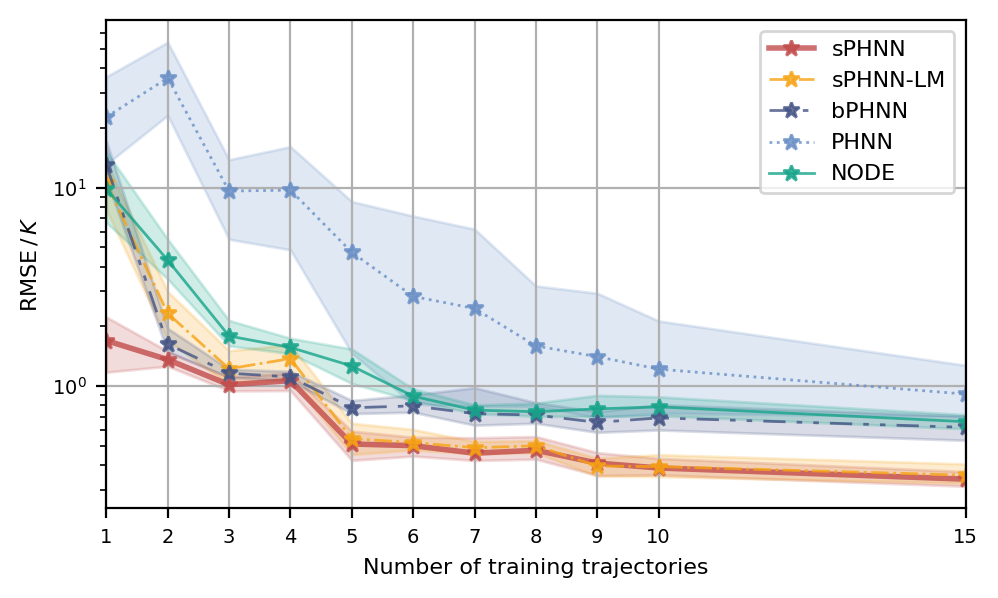

In [17]:
plot_data = {}
for model_type, model_results in results.items():
    plot_data[model_type] = {}
    for num_dat, dat_results in model_results.items():
        plot_data[model_type][num_dat] = {}
        for num_aug, aug_results in dat_results.items():
            plot_data[model_type][num_dat][num_aug] = {}
            rmses = defaultdict(list)
            for n, instance_result in enumerate(aug_results):
                for metric, value in instance_result.items():
                    if metric.endswith('_rmse'):
                        rmses[metric].append(value)

            for metric, values in rmses.items():
                plot_data[model_type][num_dat][num_aug][metric] = evaluation.get_statistics(np.array(values))

use_num_aug = 3
use_metric = 'test_rmse'

fig, ax = plt.subplots(figsize=(5, 3), dpi=PLOT_DPI)
x: list = []
for model_type, model_results in plot_data.items():
    x = list(model_results.keys())
    y_test_iqm  = [dr[use_num_aug][use_metric]['interquartile_mean'] for dr in model_results.values()]
    y_test_fq   = [dr[use_num_aug][use_metric]['first_quartile'] for dr in model_results.values()]
    y_test_tq   = [dr[use_num_aug][use_metric]['third_quartile'] for dr in model_results.values()]
    line, = ax.plot(x, y_test_iqm, marker='*', **model_style[model_type], label=model_names[model_type])
    ax.fill_between(x, y_test_fq, y_test_tq, alpha=0.2, zorder=1, color=line.get_color())

ax.set(
    xticks = x,
    xlim = (x[0], x[-1]),
    yscale = 'log',
    xlabel = 'Number of training trajectories',
    ylabel = R'$\text{RMSE}\,/\,K$',
)
ax.legend()
ax.grid(True, axis='both')
fig.tight_layout()
plt.plot()



#### Custom trajectory experiment

In [18]:
ts_eval = jnp.linspace(0, 5000, 1000)
ys_eval = np.full((ts_eval.size, 2), np.nan)
ys_eval[0,:] = 279.15
m1 = 50
m2 = 100

us_eval = np.full((ts_eval.size, 1), 279.15)
mask1 = np.logical_and(100<ts_eval, ts_eval<800)
us_eval[mask1] = 400
mask2 = ts_eval>=800
us_eval[mask2] = 310
us_eval = jnp.array(us_eval)

test_name = 'custom'

use_num_dat = [1,5,10,15]
plot_data = {}
for model_type, model_results in results.items():
    print(f'{model_type}')
    plot_data[model_type] = {}
    for num_dat, dat_results in model_results.items():
        if num_dat not in use_num_dat:
            continue
        print(f'|-num. dat.: {num_dat}')
        plot_data[model_type][num_dat] = {}
        for num_aug, aug_results in dat_results.items():
            plot_data[model_type][num_dat][num_aug] = {}
            eval_preds = []
            for n, instance_result in enumerate(aug_results):
                try:
                    ys_pred = instance_result['wrapped_model'](ts_eval, ys_eval[0], us_eval)
                except Exception as e:
                    print(f'Integration failed: {model_type}, num_dat={num_dat}, num_aug={num_aug}, instance={n}. {e}')
                eval_preds.append(ys_pred)

            plot_data[model_type][num_dat][num_aug]['ys_pred'] = evaluation.get_statistics(np.array(eval_preds))


sPHNN
|-num. dat.: 1
|-num. dat.: 5
|-num. dat.: 10
|-num. dat.: 15
sPHNN-LM
|-num. dat.: 1
|-num. dat.: 5
|-num. dat.: 10
|-num. dat.: 15
cPHNN
|-num. dat.: 1
|-num. dat.: 5
|-num. dat.: 10
|-num. dat.: 15
PHNN
|-num. dat.: 1
|-num. dat.: 5
|-num. dat.: 10
|-num. dat.: 15
NODE
|-num. dat.: 1
|-num. dat.: 5
|-num. dat.: 10
|-num. dat.: 15


C:\Users\roth\AppData\Local\Temp\ipykernel_47128\4080675187.py:46: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


[]

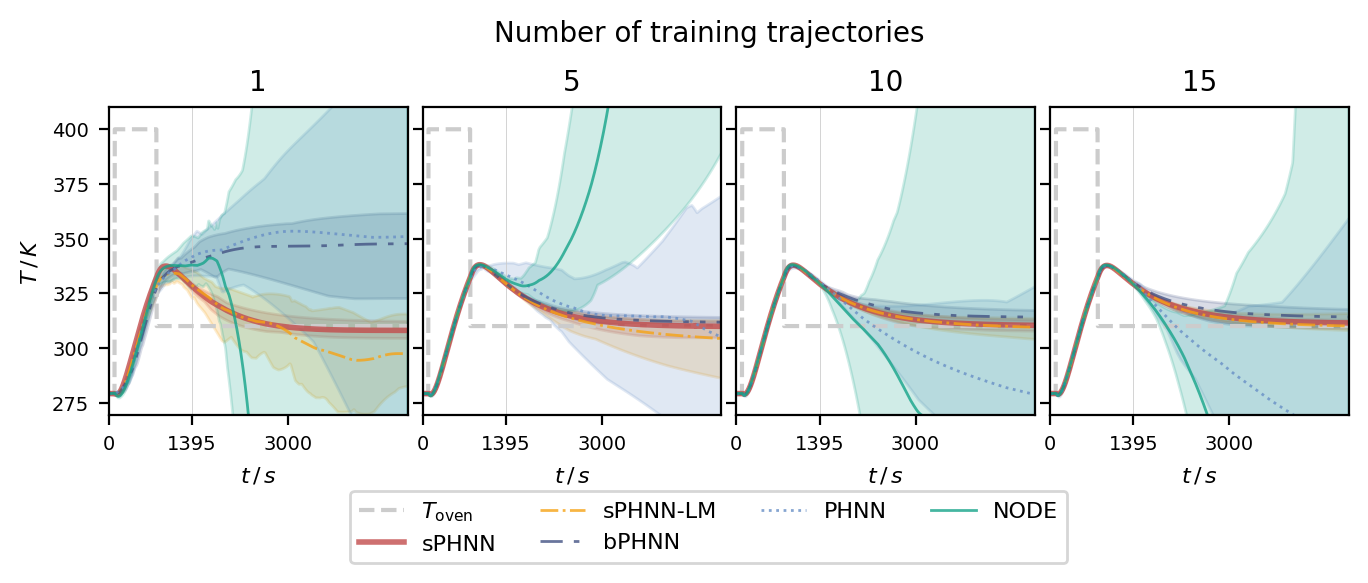

In [19]:
use_num_dat = [1,5,10,15]
use_num_aug = [3]

n_col = min(max([len(mr) for mr in plot_data.values()]), len(use_num_dat))
n_row = min(max([max([len(nr) for nr in mr.values()]) for mr in plot_data.values()]), len(use_num_aug))

fig, axes = plt.subplots(n_row, n_col, figsize=(2*n_col, 2*n_row), sharey=True, sharex=True, dpi=PLOT_DPI)
axes = np.atleast_2d(axes)

for ax in axes.flatten():
    ax.axvline(ts_train[-1], c=colors.theme_colors['grey'], ls='-', lw=0.3)#, label='Training end time')
    ax.plot(ts_eval, us_eval.squeeze(), '--', c=colors.theme_colors['grey'], label=R'$T_\text{oven}$')
    # ax.plot(ts_eval, ys_eval[:,0], '--', c='black', marker='o', lw=3, label=R'$T_A$')

for model_type, model_pd in plot_data.items():
    model_pd = {k:v for k,v in model_pd.items() if k in use_num_dat}
    for col, (num_dat, dat_pd) in enumerate(model_pd.items()):
        dat_pd = {k:v for k,v in dat_pd.items() if k in use_num_aug}
        for row, (num_aug, aug_pd) in enumerate(dat_pd.items()):
            ax = axes[row, col]

            ys_pred_iqm = aug_pd['ys_pred']['interquartile_mean'][:,0]
            ys_pred_fq  = aug_pd['ys_pred']['first_quartile'][:,0]
            ys_pred_tq  = aug_pd['ys_pred']['third_quartile'][:,0]

            line, = ax.plot(ts_eval, ys_pred_iqm, **model_style[model_type], label=model_names[model_type])
            ax.fill_between(ts_eval, ys_pred_fq, ys_pred_tq, alpha=0.2, zorder=1, color=line.get_color())

            ylabel = '$T\,/\,K$' if col==0 else ''

            ax.set(
                title=num_dat if row==0 else '',
                ylabel = ylabel,
                xticks = [0, ts_train[-1], 3000],
                # ylim=[275, 375], #[275,405],
                ylim = [us_eval.min()-10, us_eval.max()+10],
                xlabel='$t\,/\,s$' if row==axes.shape[0]-1 else '',
                xlim=[ts_eval.min(), ts_eval.max()],
            )


fig.suptitle('Number of training trajectories', y=1.15-0.05*n_row)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1+0.05*n_row), 
           bbox_transform=fig.transFigure, fancybox=True, shadow=False, ncol=4)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.tight_layout()
plt.plot()